In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
import numpy as np
import shap

pd.set_option("display.max_columns", 100)

/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_data = pd.read_csv("dataset.csv")
base_data.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float,crisis
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",45,48000.0,60000.0,2


In [4]:
data = base_data[["State", "Term", "NoEmp", "UrbanRural", "cat_activites", "bank_loan_float", "MIS_Status", "SBA_loan_float", "FranchiseCode", "LowDoc", "Bank"]]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, data["MIS_Status"], test_size=0.1, random_state=42, stratify=data["MIS_Status"])

X_train = X_train.drop("MIS_Status", axis=1)
X_test = X_test.drop("MIS_Status", axis=1)


In [6]:
preprocessor = make_pipeline(make_column_transformer((OneHotEncoder(), ["State", "LowDoc"]),remainder="passthrough"))

In [7]:
model = make_pipeline(preprocessor, RandomForestClassifier(10, max_depth=5, random_state=42))

model.fit(X_train, y_train)



ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
y_pred_encoded = []
for y in y_pred:
    if y == "P I F":
        y_pred_encoded.append(1)
    else :
        y_pred_encoded.append(0)


In [ ]:
probabilities = model.predict_proba(X_test)[:,1]

In [ ]:
print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

In [ ]:
print(classification_report(y_test, y_pred=y_pred))

In [ ]:
feature_names = model[0].get_feature_names_out()  # Extract feature names
importances = model[-1].feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance")
plt.tight_layout()
plt.show()

### LIGHTGBM

In [8]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

X_train_lgb[["State", "LowDoc", "Bank"]] = X_train_lgb[["State", "LowDoc", "Bank"]].astype("category")
X_test_lgb[["State", "LowDoc", "Bank"]] = X_test_lgb[["State", "LowDoc", "Bank"]].astype("category")



In [9]:
# preprocessor_gbm = make_pipeline(make_column_transformer((OneHotEncoder(), ["State", "LowDoc", "cat_activites"]),remainder="passthrough"))

In [10]:
lgb = LGBMClassifier(learning_rate=0.6, n_estimators=100, max_depth=13, min_child_samples=60, num_leaves=70, boosting_type="dart")
# lgb = LGBMClassifier(learning_rate=0.27785, n_estimators=192, max_depth=16, subsample=0.90, boosting_type="dart")

lgb.fit(X_train_lgb, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


LGBMClassifier(boosting_type='dart', learning_rate=0.6, max_depth=13,
               min_child_samples=60, num_leaves=70)

In [11]:
single = pd.read_csv("single.csv")
single = single[["State", "Term", "NoEmp", "UrbanRural", "cat_activites", "bank_loan_float", "SBA_loan_float", "FranchiseCode", "LowDoc", "Bank"]]
single[["State", "LowDoc", "Bank"]] = single[["State", "LowDoc", "Bank"]].astype("category")

lgb.predict(single)

array(['CHGOFF'], dtype=object)

In [12]:
# cat_b = CatBoostClassifier()
# cat_b.fit(X_test_lgb, y_train)

In [13]:
y_pred = lgb.predict(X_test_lgb)
lgb_proba = lgb.predict_proba(X_test_lgb)[:,1]
y_pred_encoded = []
for y in y_pred:
    if y == "P I F":
        y_pred_encoded.append(1)
    else :
        y_pred_encoded.append(0)

In [14]:
print("Train score : ", lgb.score(X_train_lgb, y_train))
print("Test score : ", lgb.score(X_test_lgb, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, lgb_proba))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.9606016457274479
Test score :  0.9496535694028938
ROC-AUC score : 0.978519239985054
F1-Score :  0.969613982803407


In [15]:
print(classification_report(y_test, y_pred=y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.87      0.83      0.85     15782
       P I F       0.96      0.97      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



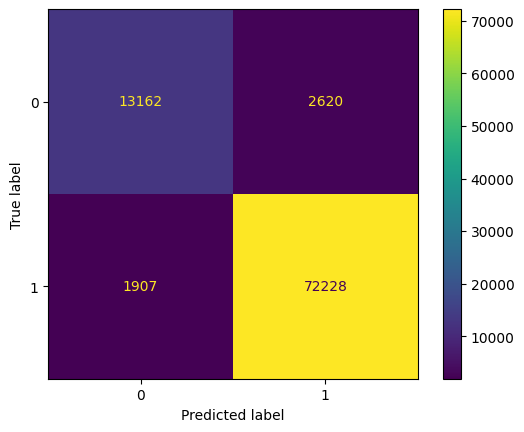

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [17]:
lgb.get_params()



{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.6,
 'max_depth': 13,
 'min_child_samples': 60,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 70,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [18]:
param = {
    "learning_rate": np.linspace(0, 1, 11),
    "max_depth": [x for x in range(1, 15, 1)],
    "n_estimators": [x for x in range(10, 101, 10)],
    "min_child_samples": [x for x in range(20, 100, 10)],
    "num_leaves": [x for x in range (10, 80, 5)]
}

In [19]:
# search = RandomizedSearchCV(lgb, param, n_iter=200, scoring='f1_macro', cv=5)

# search_grid = search.fit(X_train_lgb, y_train)



/tmp/ipykernel_9432/3274430632.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_final, x="Feature", y="Importance", palette="Set2")


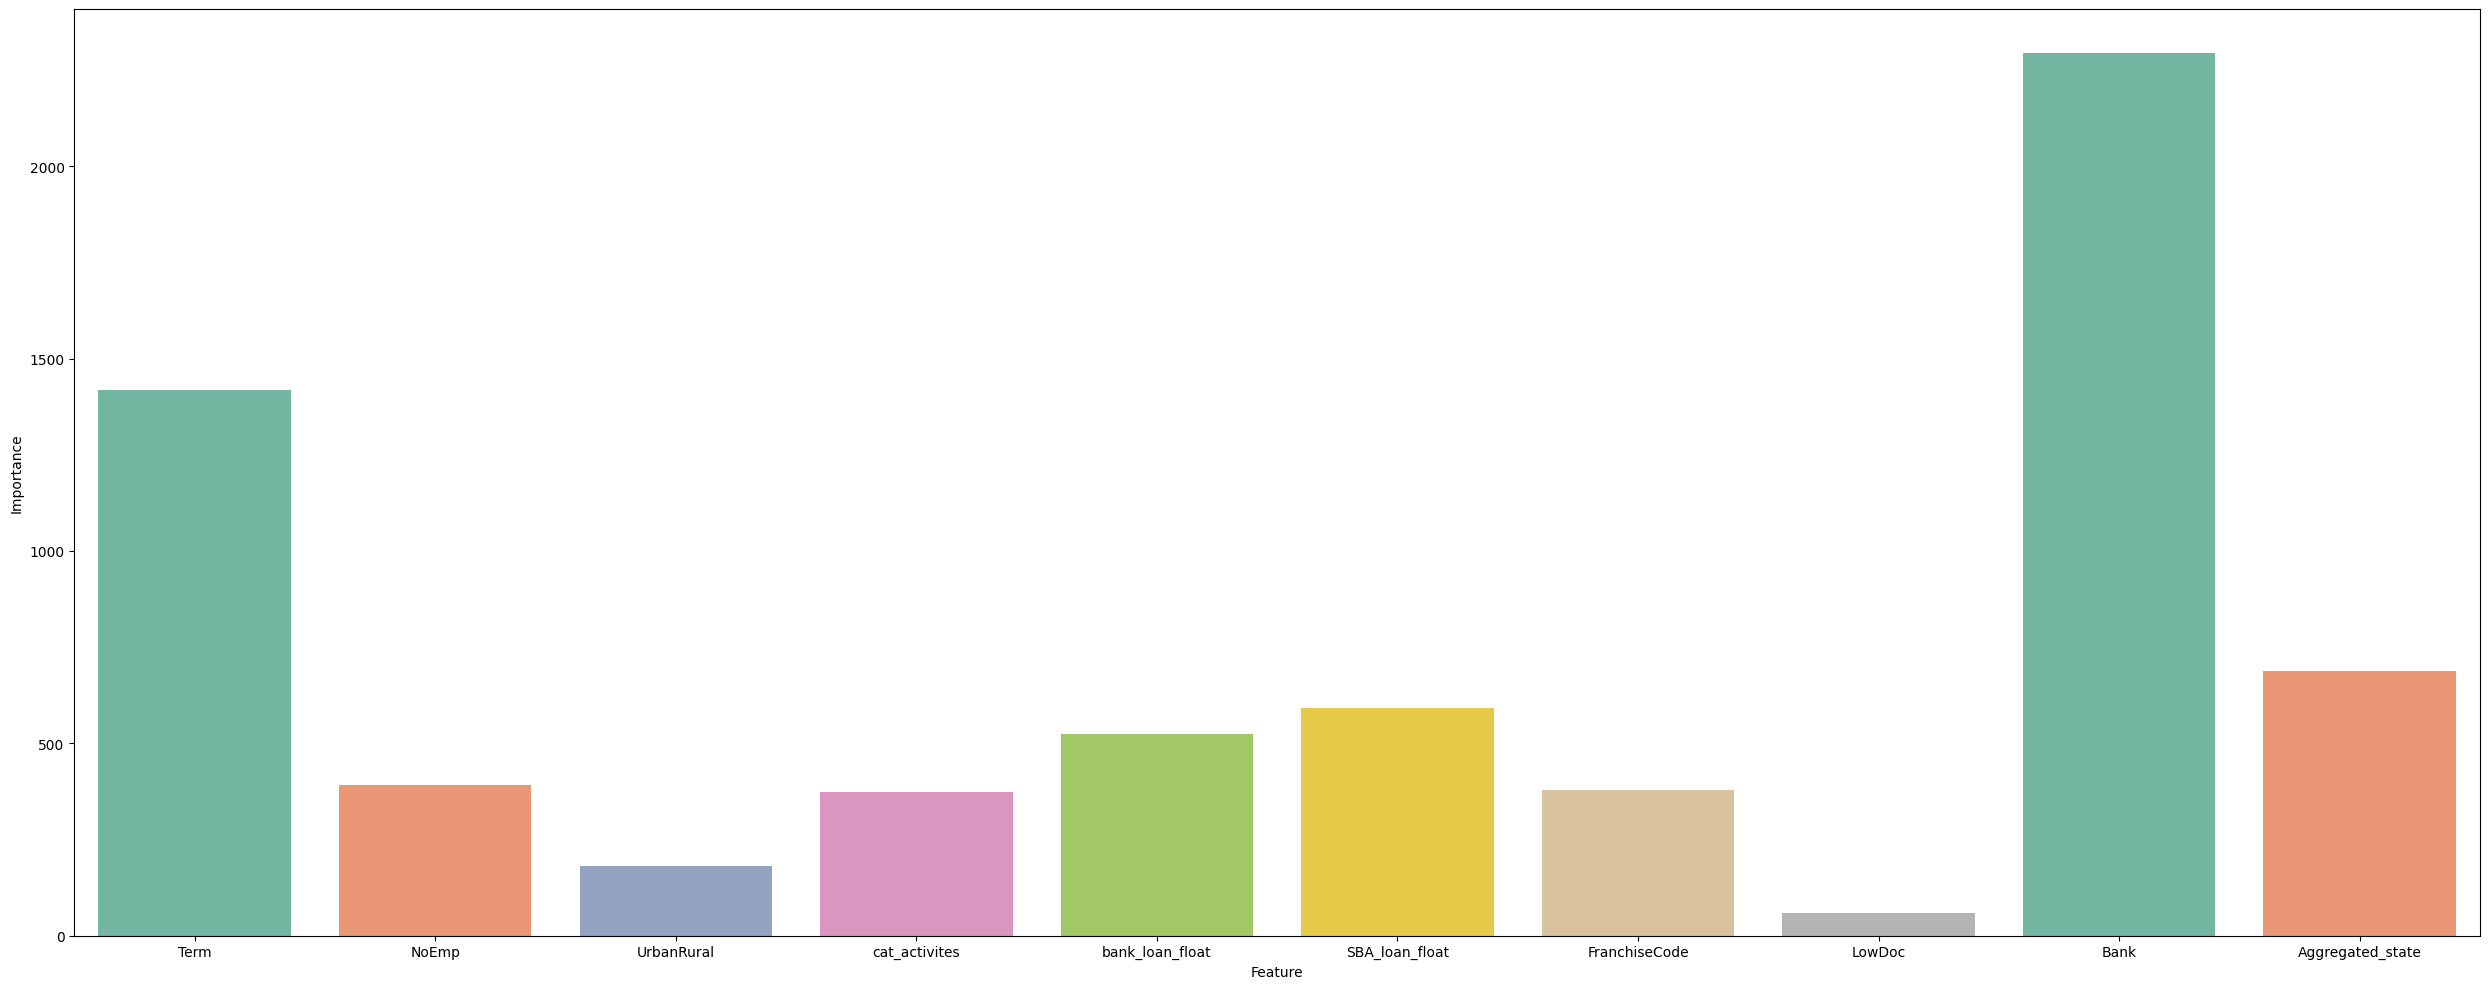

In [20]:

boost = lgb.booster_

feature_names = boost.feature_name()  # Extract feature names
importances = lgb.feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance", palette="Set2")
plt.tight_layout()
plt.show()

In [21]:
print(search_grid.best_params_)

NameError: name 'search_grid' is not defined

In [ ]:
# SHAP pour interprétabilité
explainer = shap.Explainer(lgb)
shap_values = explainer(X_test_lgb)
shap.summary_plot(shap_values, X_test_lgb)